# CSC_2021: Генерация фичей для фото лесовоза

In [1]:
import os
import re
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
print('Running openCV: ', cv2.__version__)

#import linear_features as lf

plt.rcParams['figure.figsize'] = (16,3)

%load_ext autoreload
%autoreload 2

Running openCV:  4.4.0


# Фотографии лесовоза сбоку

In [2]:
root_dir = 'part_1\\'
truck = '25\\113642_М502РУ10'

path = os.path.join(root_dir, truck)
front_images = glob.glob(os.path.join(path, 'FrontJPG', '*'))

In [3]:
print(f"Кол-во фотографий: {len(front_images)}")

Кол-во фотографий: 94


# Преобразование из широкоугольного формата

In [2]:
def get_image(path):
    stream = open(f'{path}', "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    img = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)
    return img

def show_img(image, figsize=(16, 9), ticks=False, title=False, grid=False):
    """
    show image with some parameters (just to reduce the lines of code in usage)
    :param image: image to show
    :param figsize: size of figure
    :param ticks: are x,y-ticks needed ot not
    :param title: the title for image
    :param grid: is grid needed or not
    :return:
    """
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not ticks:
        plt.xticks([]), plt.yticks([])
    if grid:
        plt.grid(which='both', color='r')
    if title:
        plt.title(title)
    plt.show()

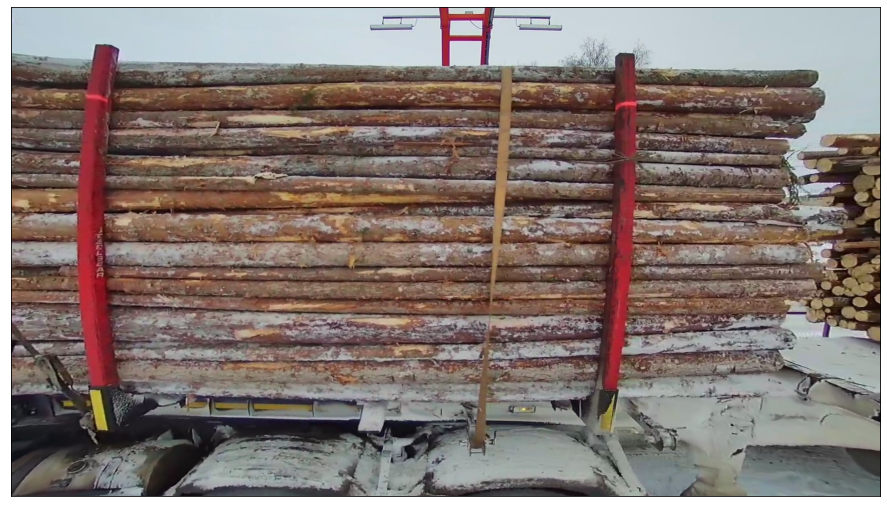

In [5]:
cur_img = get_image(front_images[10])
show_img(cur_img)

# Таблицы с данными

In [6]:
nek = pd.read_csv('C:/Users/Николай/Desktop/Project/table_nek.csv')

downloaded_days = ['02', '03', '04', '05', '06', '07', '09', '13',
                   '15', '16', '17', '18', '19', '20', '21', '22',
                   '23', '24', '25', '26', '27', '30', '31']

In [7]:
def prepare_df(df, downloaded_days=None):
    
    df['front_frames'] = df['front_frames'].apply(lambda x: x[1:-2].split()[len(x.split()) // 2][1:-2])
    df['path'] = df['path'].apply(lambda x: x.replace('scan_track_video/2020_01', 'part_1'))
    df['path'] = df[['path', 'front_frames']].apply(lambda x: '/FrontJPG/'.join(x), axis=1)
    df['day'] = df['path'].apply(lambda x: x[7:9])
    
    if downloaded_days is not None:
        df = df[df['day'].isin(downloaded_days)]
    
    df.drop(columns=['truck_N', 'trailer_N', 'pack_N', 'front_frames', 'datetime'], inplace=True)
    return df

nek = prepare_df(nek, downloaded_days)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
nek.head()

,pack_id,path,sort,length,width,height,k,volume,day
0,2020_01_21_22_224923_М636МВ_1,part_1/21/224923_М636МВ10/FrontJPG/front6.jpg,Балансы березовые,600.0,236.0,182.0,0.54,13.916448,21
1,2020_01_21_22_224923_М636МВ_2,part_1/21/224923_М636МВ10/FrontJPG/front29.jpg,Балансы березовые,600.0,236.0,180.0,0.54,13.763520,21
2,2020_01_21_06_064710_М571ОМ_1,part_1/21/064710_м571ом10/FrontJPG/front14.jpg,Бал-сы пр. хв.п. и см. хв. п.,300.0,226.0,176.0,0.64,7.636992,21
3,2020_01_21_06_064710_М571ОМ_2,part_1/21/064710_м571ом10/FrontJPG/front24.jpg,Бал-сы пр. хв.п. и см. хв. п.,300.0,226.0,186.0,0.60,7.566480,21
4,2020_01_21_06_064710_М571ОМ_3,part_1/21/064710_м571ом10/FrontJPG/front40.jpg,Бал-сы пр. хв.п. и см. хв. п.,300.0,226.0,170.0,0.60,6.915600,21


# Генерация признаков
- **цветовые (гистограммы, статистики в разных цветовых пространствах RGB, HSV и др.)**
- **геометрические (длина прямых, диаметры, углы, keypoints и др.)**
- сортность древесины
- DL (использование векторных представлений, получаемых на пред. последнем слое сети при решении связанной задачи, например: определение сорта)

__Выбор фотографий пачки, по которым будут вычислятся признаки, - не единственен. Возможные подходы:__
- центральное фото 
- начало, середина и конец 
- все фото
- др.

__Далее рассотрим пример для генерации признаков по одному изображению__

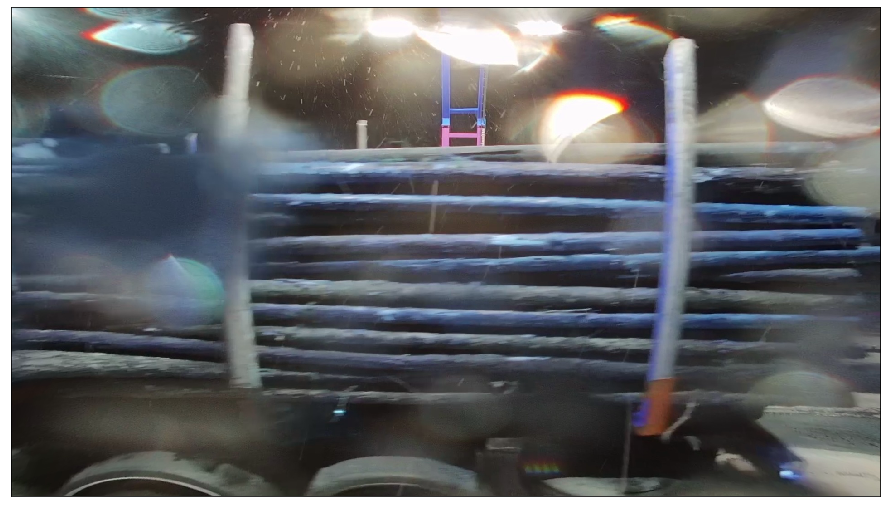

In [9]:
cur_img = cv2.cvtColor(get_image(nek['path'][13]), cv2.COLOR_BGR2RGB)

show_img(cur_img)

## Цветовые признаки

In [10]:
def get_pixel_hist(flettened_image, n_bins=256, arange=(0, 255)):
    hist = np.zeros((flettened_image.shape[1], n_bins))
    bins = None
    for i in range(len(hist)):
        hist[i], bins = np.histogram(flettened_image[:, i], bins=n_bins, range=arange, density=False)
        hist[i] *= np.diff(bins)
    return hist, bins


def get_stats(array):
    stats = {}

    if array.size == 0:
        median, std = np.nan, np.nan
    else:
        median = np.median(array, axis=0)
        std = np.std(array, axis=0)

    stats.update({
        'median': median,
        'std': std
    })
    return stats


def extract_photo_features_color(array, name, n_bins, arange):
    hist_dict, stats_dict = {}, {}
    array = array.reshape(-1, 3)
    
    hist, bins = get_pixel_hist(array, n_bins=n_bins, arange=arange)
    stats = get_stats(array)
    
    for i, c in enumerate(name.split('_')[1]):
        hist_dict.update({
                f'{c}_hist_{np.round(from_, 3)}_{np.round(to_, 3)}': v 
                for from_, to_, v in zip(bins[:-1], bins[1:], hist[i])
            })
        
        stats_dict.update({
                f'{c}_{k}': v[i] 
                for k, v in stats.items()
            })
    
    return hist_dict, stats_dict

In [11]:
rgb_hist, rgb_stats = extract_photo_features_color(cur_img, '_rgb', n_bins=10, arange=(0, 255))
hsv_hist, hsv_stats = extract_photo_features_color(cv2.cvtColor(cur_img, cv2.COLOR_RGB2HSV),
                                                   '_hsv', n_bins=10, arange=(0, 255))

In [12]:
rgb_hist

{'r_hist_0.0_25.5': 1898526.0,
 'r_hist_25.5_51.0': 9678525.0,
 'r_hist_51.0_76.5': 10366744.5,
 'r_hist_76.5_102.0': 10391811.0,
 'r_hist_102.0_127.5': 7569802.5,
 'r_hist_127.5_153.0': 4718902.5,
 'r_hist_153.0_178.5': 4143138.0,
 'r_hist_178.5_204.0': 2180760.0,
 'r_hist_204.0_229.5': 1058071.5,
 'r_hist_229.5_255.0': 870519.0,
 'g_hist_0.0_25.5': 1850458.5,
 'g_hist_25.5_51.0': 9972004.5,
 'g_hist_51.0_76.5': 13220577.0,
 'g_hist_76.5_102.0': 9235768.5,
 'g_hist_102.0_127.5': 6663099.0,
 'g_hist_127.5_153.0': 4837299.0,
 'g_hist_153.0_178.5': 3491919.0,
 'g_hist_178.5_204.0': 1774723.5,
 'g_hist_204.0_229.5': 847161.0,
 'g_hist_229.5_255.0': 983790.0,
 'b_hist_0.0_25.5': 1432564.5,
 'b_hist_25.5_51.0': 11000878.5,
 'b_hist_51.0_76.5': 13980808.5,
 'b_hist_76.5_102.0': 9315966.0,
 'b_hist_102.0_127.5': 6732255.0,
 'b_hist_127.5_153.0': 4150227.0,
 'b_hist_153.0_178.5': 2609338.5,
 'b_hist_178.5_204.0': 1578220.5,
 'b_hist_204.0_229.5': 907264.5,
 'b_hist_229.5_255.0': 1169277.0}

In [13]:
rgb_stats, hsv_stats

({'r_median': 86.0,
  'r_std': 51.5253268165097,
  'g_median': 80.0,
  'g_std': 50.725130420433054,
  'b_median': 77.0,
  'b_std': 50.59338185249949},
 {'h_median': 50.0,
  'h_std': 51.04555011470299,
  's_median': 42.0,
  's_std': 31.663948160020766,
  'v_median': 92.0,
  'v_std': 53.22705025981215})

In [3]:
import torch
import torchvision.transforms as T
import torchvision
import datetime
from PIL import Image

from sklearn.model_selection import train_test_split

#densenet201 = torch.load('models/densenet201.pth')
#densenet201.eval()
#resnet101 = torch.load('models/resnet101.pth')
#resnet101.eval()

In [15]:
transform = T.Compose(
           [T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
            ])

with torch.no_grad():
    image = Image.open(nek['path'][0])
    area = (750, 180, 1400, 970)
    image = image.crop(area)
    image = transform(image)
    image = torch.unsqueeze(image, 0)
    image = image.cuda()
    
    t = np.argmax(densenet201(image).cpu().numpy())
    print(t)

0


**time consuming**

In [80]:
'''
df2 = pd.DataFrame()

for path in nek['path']:
    img = cv2.cvtColor(get_image(path), cv2.COLOR_BGR2RGB)
    rgb_hist, rgb_stats = extract_photo_features_color(img, '_rgb', n_bins=10, arange=(0, 255))
    hsv_hist, hsv_stats = extract_photo_features_color(cv2.cvtColor(img, cv2.COLOR_RGB2HSV),
                                                       '_hsv', n_bins=10, arange=(0, 255))
    
    frames_features = {
    'path': path,
    **rgb_hist, **rgb_stats,
    **hsv_hist, **hsv_stats,
    }
    df2 = df2.append(frames_features, ignore_index=True)

df2.to_csv('features_table.csv')
'''

In [85]:
df2 = pd.read_csv('features_table.csv')

In [17]:
nek = pd.merge(nek, df2, on=['path'])

In [87]:
nek

,Unnamed: 0,pack_id,path,sort,length,width,height,k,volume,day,...,v_hist_127.5_153.0,v_hist_153.0_178.5,v_hist_178.5_204.0,v_hist_204.0_229.5,v_hist_229.5_255.0,v_hist_25.5_51.0,v_hist_51.0_76.5,v_hist_76.5_102.0,v_median,v_std
0,0,2020_01_21_22_224923_М636МВ_1,part_1/21/224923_М636МВ10/FrontJPG/front6.jpg,1,600.0,236.0,182.0,0.54,13.916448,21,...,4722166.5,5265061.5,4555269.0,3142008.0,1335180.0,13438500.0,9731488.5,5199424.5,89.0,62.726942
1,1,2020_01_21_22_224923_М636МВ_2,part_1/21/224923_М636МВ10/FrontJPG/front29.jpg,1,600.0,236.0,180.0,0.54,13.763520,21,...,4873764.0,5045430.0,4085865.0,2226889.5,1354407.0,14192739.0,9442089.0,5954760.0,86.0,60.127581
2,2,2020_01_21_06_064710_М571ОМ_1,part_1/21/064710_м571ом10/FrontJPG/front14.jpg,0,300.0,226.0,176.0,0.64,7.636992,21,...,5536968.0,3887449.5,2250196.5,1247485.5,1719618.0,7698450.0,12264888.0,10004925.0,88.0,54.457244
3,3,2020_01_21_06_064710_М571ОМ_2,part_1/21/064710_м571ом10/FrontJPG/front24.jpg,0,300.0,226.0,186.0,0.60,7.566480,21,...,3528333.0,1901229.0,1834419.0,1243533.0,1806547.5,10623351.0,14051851.5,9275268.0,77.0,53.979654
4,4,2020_01_21_06_064710_М571ОМ_3,part_1/21/064710_м571ом10/FrontJPG/front40.jpg,0,300.0,226.0,170.0,0.60,6.915600,21,...,2660517.0,1679940.0,1872337.5,1221144.0,1882869.0,11116954.5,14506083.0,9124078.5,73.0,54.834528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,1560,2020_01_27_20_204553_М496РУ_4,part_1/27/204553_м496ру10/FrontJPG/front52.jpg,0,300.0,234.0,240.0,0.67,11.288160,27,...,5424411.0,6347230.5,4913901.0,3747072.0,2387106.0,5212812.0,11313789.0,7520077.5,111.0,60.265703
1561,1561,2020_01_27_02_021645_М457РУ_1,part_1/27/021645_М457РУ10/FrontJPG/front15.jpg,0,550.0,230.0,210.0,0.59,15.673350,27,...,6264712.5,5718426.0,5108568.0,3868299.0,2249202.0,9610491.0,8950500.0,5120145.0,114.0,62.883795
1562,1562,2020_01_27_02_021645_М457РУ_2,part_1/27/021645_М457РУ10/FrontJPG/front38.jpg,0,550.0,230.0,200.0,0.59,14.927000,27,...,5697414.0,4896867.0,4489300.5,3285573.0,1508478.0,10444672.5,10044093.0,5653375.5,103.0,60.001154
1563,1563,2020_01_27_17_174133_М493РУ_1,part_1/27/174133_м493ру10/FrontJPG/front8.jpg,1,600.0,232.0,180.0,0.52,13.029120,27,...,5865153.0,6433599.0,5644093.5,3577063.5,1537012.5,12175281.0,7182610.5,4676037.0,112.0,63.457556


In [87]:
def choose_class_4cl(str):
    if str == 'Балансы березовые':
        return 1
    elif str == 'Бал-сы пр. хв.п. и см. хв. п.':
        return 0
    elif str == 'Балансы еловые':
        return 2
    elif str == 'Балансы сосновые':
        return 3

nek['sort'] = nek['sort'].apply(lambda x: choose_class_4cl(x))

In [88]:
#nek.to_csv('feature_table_nek.csv')

In [34]:
nek = pd.read_csv('feature_table_nek.csv')

In [35]:
data = nek.drop(columns=['day', 'volume', 'path', 'pack_id', 'Unnamed: 0'])

In [36]:
data_X = data.drop(columns=['k'])
data_y = data['k']

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [38]:
#scaler = StandardScaler()
#data_X = scaler.fit_transform(data_X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2,
                                                    random_state=13)

# Обучим бустинг

In [42]:
params = {'n_estimators': 3000,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.001,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=6, min_samples_split=5,
                          n_estimators=3000)

In [43]:
mae = mean_absolute_error(y_test, np.round(reg.predict(X_test), 2))
mse = mean_squared_error(y_test, np.round(reg.predict(X_test), 2))
r2 = r2_score(y_test, np.round(reg.predict(X_test), 2))
mape = mean_absolute_percentage_error(y_test, np.round(reg.predict(X_test), 2))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("Rsquared on test set: {:.4f}".format(r2))
print("The mean absolute percentage error (MAPE) on test set: {:.4f}".format(mape))

The mean absolute error (MAE) on test set: 0.0090
The mean squared error (MSE) on test set: 0.0003
Rsquared on test set: 0.7779
The mean absolute percentage error (MAPE) on test set: 0.0145


**Важность признаков**

In [44]:
from sklearn.inspection import permutation_importance

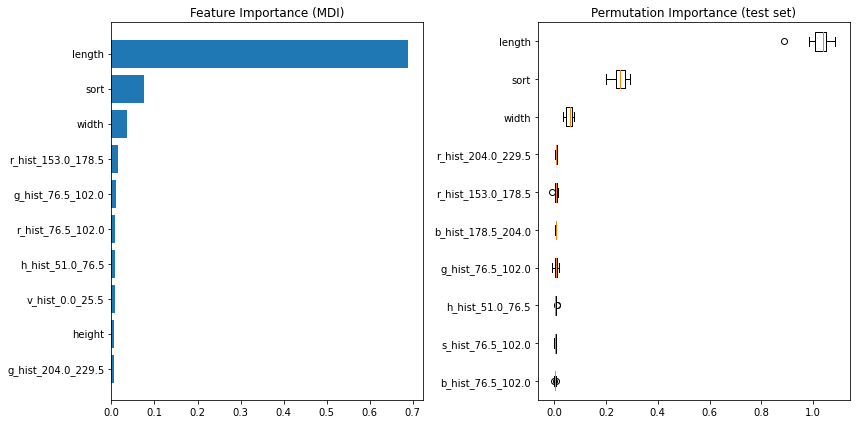

In [55]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos[-10:], feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos[-10:], np.array(data_X.columns)[sorted_idx][-10:])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(data_X.columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Нейронка (результат хуже)

In [58]:
import torch

In [62]:
data_X = data.drop(columns=['k'])
data_y = data['k']

scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2,
                                                    random_state=13)

In [82]:
class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.fc1 = torch.nn.Linear(76, 80)  # 5*5 from image dimension
        self.fc2 = torch.nn.Linear(80, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net()

In [83]:
inputs_train = torch.from_numpy(X_train.astype(np.float32))
targets_train = torch.from_numpy(y_train.values.astype(np.float32))
inputs_val = torch.from_numpy(X_test.astype(np.float32))
targets_val = torch.from_numpy(y_test.values.astype(np.float32))

In [84]:
opt = torch.optim.SGD(net.parameters(), lr=3e-2)

In [85]:
import torch.nn.functional as F

l = torch.nn.L1Loss()

In [86]:
num_epochs = 2000
val_hist = []
train_hist = []
for epoch in range(num_epochs):
#forward feed
    y_pred_train = net(inputs_train.requires_grad_())
    y_pred_val = net(inputs_val.requires_grad_())
    #calculate the loss
    loss_train= l(y_pred_train, targets_train)
    loss_val = l(y_pred_val, targets_val)

    #backward propagation: calculate gradients
    loss_train.backward()

    #update the weights
    opt.step()

    #clear out the gradients from the last step loss.backward()
    opt.zero_grad()
    

    train_hist.append(loss_train)
    val_hist.append(loss_val)
    print('epoch {}, loss {}'.format(epoch, loss_train.item()))

epoch 0, loss 0.527641236782074
epoch 1, loss 0.3825188875198364
epoch 2, loss 0.27257677912712097
epoch 3, loss 0.2077483981847763
epoch 4, loss 0.1780482679605484
epoch 5, loss 0.163407564163208
epoch 6, loss 0.15256088972091675
epoch 7, loss 0.14344073832035065
epoch 8, loss 0.13563765585422516
epoch 9, loss 0.1289309859275818
epoch 10, loss 0.12308722734451294
epoch 11, loss 0.11801653355360031
epoch 12, loss 0.11373812705278397
epoch 13, loss 0.11001099646091461
epoch 14, loss 0.10671456158161163
epoch 15, loss 0.10384750366210938
epoch 16, loss 0.10134023427963257
epoch 17, loss 0.09906569868326187
epoch 18, loss 0.0969475582242012
epoch 19, loss 0.09497947990894318
epoch 20, loss 0.09310191869735718
epoch 21, loss 0.09131225943565369
epoch 22, loss 0.08958739042282104
epoch 23, loss 0.08794359862804413
epoch 24, loss 0.0863770842552185
epoch 25, loss 0.08487816900014877
epoch 26, loss 0.08345599472522736
epoch 27, loss 0.08208482712507248
epoch 28, loss 0.08076787739992142
epoch

epoch 235, loss 0.06397246569395065
epoch 236, loss 0.06263617426156998
epoch 237, loss 0.06385862827301025
epoch 238, loss 0.06254056841135025
epoch 239, loss 0.06393488496541977
epoch 240, loss 0.06261098384857178
epoch 241, loss 0.06400736421346664
epoch 242, loss 0.062491875141859055
epoch 243, loss 0.06378307938575745
epoch 244, loss 0.0625348761677742
epoch 245, loss 0.06372008472681046
epoch 246, loss 0.06250160187482834
epoch 247, loss 0.06353335082530975
epoch 248, loss 0.062460582703351974
epoch 249, loss 0.06361888349056244
epoch 250, loss 0.06242644041776657
epoch 251, loss 0.06350292265415192
epoch 252, loss 0.06229620426893234
epoch 253, loss 0.06325602531433105
epoch 254, loss 0.062284041196107864
epoch 255, loss 0.06326117366552353
epoch 256, loss 0.06238140910863876
epoch 257, loss 0.06327167898416519
epoch 258, loss 0.0622909776866436
epoch 259, loss 0.06306447088718414
epoch 260, loss 0.06217923387885094
epoch 261, loss 0.0628892257809639
epoch 262, loss 0.0620434805

epoch 464, loss 0.05471458286046982
epoch 465, loss 0.05625700205564499
epoch 466, loss 0.05466178059577942
epoch 467, loss 0.05607406795024872
epoch 468, loss 0.05466217175126076
epoch 469, loss 0.05606677383184433
epoch 470, loss 0.05458327382802963
epoch 471, loss 0.05598940700292587
epoch 472, loss 0.05452337488532066
epoch 473, loss 0.0558624230325222
epoch 474, loss 0.05444297194480896
epoch 475, loss 0.05565433204174042
epoch 476, loss 0.05441765487194061
epoch 477, loss 0.05575164034962654
epoch 478, loss 0.054388515651226044
epoch 479, loss 0.05579989776015282
epoch 480, loss 0.05429394915699959
epoch 481, loss 0.05567868426442146
epoch 482, loss 0.05423818901181221
epoch 483, loss 0.05568908154964447
epoch 484, loss 0.054164234548807144
epoch 485, loss 0.05567551404237747
epoch 486, loss 0.05406610667705536
epoch 487, loss 0.05545510724186897
epoch 488, loss 0.05400824546813965
epoch 489, loss 0.05550573021173477
epoch 490, loss 0.05392029881477356
epoch 491, loss 0.055269725

epoch 692, loss 0.04826910421252251
epoch 693, loss 0.05102771893143654
epoch 694, loss 0.04827537015080452
epoch 695, loss 0.05095875263214111
epoch 696, loss 0.04821958392858505
epoch 697, loss 0.05100259184837341
epoch 698, loss 0.048167113214731216
epoch 699, loss 0.05085621401667595
epoch 700, loss 0.048119667917490005
epoch 701, loss 0.05086522176861763
epoch 702, loss 0.04808776080608368
epoch 703, loss 0.05090823397040367
epoch 704, loss 0.04801853746175766
epoch 705, loss 0.05076425522565842
epoch 706, loss 0.0479692742228508
epoch 707, loss 0.05076655372977257
epoch 708, loss 0.04797061160206795
epoch 709, loss 0.050768736749887466
epoch 710, loss 0.04791203886270523
epoch 711, loss 0.050684574991464615
epoch 712, loss 0.047840118408203125
epoch 713, loss 0.050718870013952255
epoch 714, loss 0.047819335013628006
epoch 715, loss 0.05062485113739967
epoch 716, loss 0.04776521027088165
epoch 717, loss 0.05056052654981613
epoch 718, loss 0.04776906594634056
epoch 719, loss 0.0505

epoch 919, loss 0.047789011150598526
epoch 920, loss 0.043542422354221344
epoch 921, loss 0.047780100256204605
epoch 922, loss 0.04347844794392586
epoch 923, loss 0.04768390953540802
epoch 924, loss 0.043503887951374054
epoch 925, loss 0.04780811071395874
epoch 926, loss 0.043403856456279755
epoch 927, loss 0.0477040633559227
epoch 928, loss 0.04339446499943733
epoch 929, loss 0.047740064561367035
epoch 930, loss 0.043336134403944016
epoch 931, loss 0.04764893651008606
epoch 932, loss 0.04334476962685585
epoch 933, loss 0.047686874866485596
epoch 934, loss 0.04326103255152702
epoch 935, loss 0.047478485852479935
epoch 936, loss 0.04334067925810814
epoch 937, loss 0.047626130282878876
epoch 938, loss 0.04321477562189102
epoch 939, loss 0.04758356139063835
epoch 940, loss 0.04320214316248894
epoch 941, loss 0.047590021044015884
epoch 942, loss 0.04314856976270676
epoch 943, loss 0.04749317094683647
epoch 944, loss 0.04313914105296135
epoch 945, loss 0.04754669964313507
epoch 946, loss 0.

epoch 1144, loss 0.039810746908187866
epoch 1145, loss 0.04586135596036911
epoch 1146, loss 0.03979671746492386
epoch 1147, loss 0.04589584469795227
epoch 1148, loss 0.03974223509430885
epoch 1149, loss 0.04574224352836609
epoch 1150, loss 0.03970829397439957
epoch 1151, loss 0.04586408659815788
epoch 1152, loss 0.03969160094857216
epoch 1153, loss 0.045866917818784714
epoch 1154, loss 0.03965102508664131
epoch 1155, loss 0.045776087790727615
epoch 1156, loss 0.0396132692694664
epoch 1157, loss 0.04582398012280464
epoch 1158, loss 0.03958270326256752
epoch 1159, loss 0.04576459527015686
epoch 1160, loss 0.0395425409078598
epoch 1161, loss 0.04581510275602341
epoch 1162, loss 0.03951946645975113
epoch 1163, loss 0.04579008370637894
epoch 1164, loss 0.03947649896144867
epoch 1165, loss 0.04563963785767555
epoch 1166, loss 0.03946678340435028
epoch 1167, loss 0.04576776549220085
epoch 1168, loss 0.03943870961666107
epoch 1169, loss 0.045766837894916534
epoch 1170, loss 0.03941426798701286

epoch 1367, loss 0.044717371463775635
epoch 1368, loss 0.03666698560118675
epoch 1369, loss 0.04473593086004257
epoch 1370, loss 0.036612771451473236
epoch 1371, loss 0.04457394778728485
epoch 1372, loss 0.03661379590630531
epoch 1373, loss 0.04474466294050217
epoch 1374, loss 0.03657439723610878
epoch 1375, loss 0.04470464959740639
epoch 1376, loss 0.036522094160318375
epoch 1377, loss 0.044611856341362
epoch 1378, loss 0.036519598215818405
epoch 1379, loss 0.044709257781505585
epoch 1380, loss 0.03646250441670418
epoch 1381, loss 0.04454771429300308
epoch 1382, loss 0.036481019109487534
epoch 1383, loss 0.04465140029788017
epoch 1384, loss 0.03643754497170448
epoch 1385, loss 0.044647492468357086
epoch 1386, loss 0.0364297516644001
epoch 1387, loss 0.044680677354335785
epoch 1388, loss 0.03637314960360527
epoch 1389, loss 0.044552676379680634
epoch 1390, loss 0.03639619052410126
epoch 1391, loss 0.04465273767709732
epoch 1392, loss 0.036331791430711746
epoch 1393, loss 0.044620051980

epoch 1586, loss 0.03417229279875755
epoch 1587, loss 0.04392782971262932
epoch 1588, loss 0.034074947237968445
epoch 1589, loss 0.04380112513899803
epoch 1590, loss 0.03411030024290085
epoch 1591, loss 0.043895453214645386
epoch 1592, loss 0.03407827392220497
epoch 1593, loss 0.04383816570043564
epoch 1594, loss 0.034050434827804565
epoch 1595, loss 0.04383271187543869
epoch 1596, loss 0.03404008969664574
epoch 1597, loss 0.04396560788154602
epoch 1598, loss 0.03399334475398064
epoch 1599, loss 0.043796200305223465
epoch 1600, loss 0.033992961049079895
epoch 1601, loss 0.04389648884534836
epoch 1602, loss 0.03395107388496399
epoch 1603, loss 0.04365939646959305
epoch 1604, loss 0.03405245393514633
epoch 1605, loss 0.0439416728913784
epoch 1606, loss 0.0339115746319294
epoch 1607, loss 0.04364549368619919
epoch 1608, loss 0.034015730023384094
epoch 1609, loss 0.043930783867836
epoch 1610, loss 0.03387099504470825
epoch 1611, loss 0.04364263266324997
epoch 1612, loss 0.03397667780518532

epoch 1808, loss 0.03209308907389641
epoch 1809, loss 0.04302928224205971
epoch 1810, loss 0.03217068687081337
epoch 1811, loss 0.043128397315740585
epoch 1812, loss 0.032126300036907196
epoch 1813, loss 0.0431210920214653
epoch 1814, loss 0.03211954981088638
epoch 1815, loss 0.04324847832322121
epoch 1816, loss 0.03203173726797104
epoch 1817, loss 0.04299720376729965
epoch 1818, loss 0.03211142122745514
epoch 1819, loss 0.04329089820384979
epoch 1820, loss 0.031961504369974136
epoch 1821, loss 0.04288991168141365
epoch 1822, loss 0.0321396067738533
epoch 1823, loss 0.04329371824860573
epoch 1824, loss 0.03192828223109245
epoch 1825, loss 0.04298033192753792
epoch 1826, loss 0.032035909593105316
epoch 1827, loss 0.043136171996593475
epoch 1828, loss 0.031969502568244934
epoch 1829, loss 0.04302903264760971
epoch 1830, loss 0.03199329599738121
epoch 1831, loss 0.04324507340788841
epoch 1832, loss 0.03187795355916023
epoch 1833, loss 0.04289178177714348
epoch 1834, loss 0.032028581947088

# Дерево

In [94]:
data_X = data.drop(columns=['k'])
data_y = data['k']

scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2,
                                                    random_state=13)

In [95]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [96]:
mae = mean_absolute_error(y_test, np.round(reg.predict(X_test), 2))
mse = mean_squared_error(y_test, np.round(reg.predict(X_test), 2))
r2 = r2_score(y_test, np.round(reg.predict(X_test), 2))
mape = mean_absolute_percentage_error(y_test, np.round(reg.predict(X_test), 2))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("Rsquared on test set: {:.4f}".format(r2))
print("The mean absolute percentage error (MAPE) on test set: {:.4f}".format(mape))

The mean absolute error (MAE) on test set: 0.0295
The mean squared error (MSE) on test set: 0.0014
Rsquared on test set: -0.1468
The mean absolute percentage error (MAPE) on test set: 0.0505


# Используем свои предсказания классов

In [10]:
nek = pd.read_csv('feature_table_nek.csv')

In [11]:
densenet201 = torch.load('models/densenet201_100.pth')
densenet201.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [12]:
nek = nek.drop(columns=['sort', 'Unnamed: 0'])
nek.head()

,pack_id,path,length,width,height,k,volume,day,b_hist_0.0_25.5,b_hist_102.0_127.5,...,v_hist_127.5_153.0,v_hist_153.0_178.5,v_hist_178.5_204.0,v_hist_204.0_229.5,v_hist_229.5_255.0,v_hist_25.5_51.0,v_hist_51.0_76.5,v_hist_76.5_102.0,v_median,v_std
0,2020_01_21_22_224923_М636МВ_1,part_1/21/224923_М636МВ10/FrontJPG/front6.jpg,600.0,236.0,182.0,0.54,13.916448,21,3968310.0,5454807.0,...,4722166.5,5265061.5,4555269.0,3142008.0,1335180.0,13438500.0,9731488.5,5199424.5,89.0,62.726942
1,2020_01_21_22_224923_М636МВ_2,part_1/21/224923_М636МВ10/FrontJPG/front29.jpg,600.0,236.0,180.0,0.54,13.763520,21,1882206.0,5601202.5,...,4873764.0,5045430.0,4085865.0,2226889.5,1354407.0,14192739.0,9442089.0,5954760.0,86.0,60.127581
2,2020_01_21_06_064710_М571ОМ_1,part_1/21/064710_м571ом10/FrontJPG/front14.jpg,300.0,226.0,176.0,0.64,7.636992,21,2566957.5,3823623.0,...,5536968.0,3887449.5,2250196.5,1247485.5,1719618.0,7698450.0,12264888.0,10004925.0,88.0,54.457244
3,2020_01_21_06_064710_М571ОМ_2,part_1/21/064710_м571ом10/FrontJPG/front24.jpg,300.0,226.0,186.0,0.60,7.566480,21,3234394.5,3148485.0,...,3528333.0,1901229.0,1834419.0,1243533.0,1806547.5,10623351.0,14051851.5,9275268.0,77.0,53.979654
4,2020_01_21_06_064710_М571ОМ_3,part_1/21/064710_м571ом10/FrontJPG/front40.jpg,300.0,226.0,170.0,0.60,6.915600,21,3356743.5,3419371.5,...,2660517.0,1679940.0,1872337.5,1221144.0,1882869.0,11116954.5,14506083.0,9124078.5,73.0,54.834528


In [13]:
input_size = 224
batch_size = 32

transform = T.Compose(
           [T.Resize(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
            ])

class WoodDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image = Image.open(row['path'])
        area = (750, 180, 1400, 970)
        image = image.crop(area)
        if self.transform:
            image = self.transform(image)
        id = row['pack_id']
        
        return (image, id)
    
dataset = WoodDataset(nek, transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
import torchvision.models as models
import time
import copy


df3 = pd.DataFrame(columns = ['pack_id', 'out_1', 'out_2', 'out_3', 'out_4'])
           
densenet201.eval()   # Set model to evaluate mode

for inputs, ids in dataloader:
    inputs = inputs.to(device)
    ids = np.asarray(ids)

    outputs = densenet201(inputs)
    dta = np.hstack((ids.reshape(-1, 1), outputs.cpu().detach().numpy()))
    df3 = df3.append(pd.DataFrame(dta, columns=df3.columns), ignore_index=True)
    
    

In [15]:
nek = pd.merge(nek, df3, on=['pack_id'])

In [16]:
nek.head()

,pack_id,path,length,width,height,k,volume,day,b_hist_0.0_25.5,b_hist_102.0_127.5,...,v_hist_229.5_255.0,v_hist_25.5_51.0,v_hist_51.0_76.5,v_hist_76.5_102.0,v_median,v_std,out_1,out_2,out_3,out_4
0,2020_01_21_22_224923_М636МВ_1,part_1/21/224923_М636МВ10/FrontJPG/front6.jpg,600.0,236.0,182.0,0.54,13.916448,21,3968310.0,5454807.0,...,1335180.0,13438500.0,9731488.5,5199424.5,89.0,62.726942,3.9509003,-0.7865582,-1.2814976,-2.7954483
1,2020_01_21_22_224923_М636МВ_2,part_1/21/224923_М636МВ10/FrontJPG/front29.jpg,600.0,236.0,180.0,0.54,13.763520,21,1882206.0,5601202.5,...,1354407.0,14192739.0,9442089.0,5954760.0,86.0,60.127581,-0.26780736,2.6590817,-0.6129748,-2.1341991
2,2020_01_21_06_064710_М571ОМ_1,part_1/21/064710_м571ом10/FrontJPG/front14.jpg,300.0,226.0,176.0,0.64,7.636992,21,2566957.5,3823623.0,...,1719618.0,7698450.0,12264888.0,10004925.0,88.0,54.457244,3.220485,-1.3546406,-0.8562173,-1.493926
3,2020_01_21_06_064710_М571ОМ_2,part_1/21/064710_м571ом10/FrontJPG/front24.jpg,300.0,226.0,186.0,0.60,7.566480,21,3234394.5,3148485.0,...,1806547.5,10623351.0,14051851.5,9275268.0,77.0,53.979654,2.714723,0.6971189,-1.7185006,-1.6859157
4,2020_01_21_06_064710_М571ОМ_3,part_1/21/064710_м571ом10/FrontJPG/front40.jpg,300.0,226.0,170.0,0.60,6.915600,21,3356743.5,3419371.5,...,1882869.0,11116954.5,14506083.0,9124078.5,73.0,54.834528,2.342815,-0.0033062166,-0.8447315,-1.686714


In [17]:
data = nek.drop(columns=['day', 'volume', 'path', 'pack_id'])

In [18]:
data_X = data.drop(columns=['k'])
data_y = data['k']

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [20]:
scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2,
                                                    random_state=13)

## Бустинг

In [22]:
params = {'n_estimators': 5000,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.002,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.002, max_depth=6, min_samples_split=5,
                          n_estimators=5000)

In [25]:
mae = mean_absolute_error(y_test, np.round(reg.predict(X_test), 2))
mse = mean_squared_error(y_test, np.round(reg.predict(X_test), 2))
r2 = r2_score(y_test, np.round(reg.predict(X_test), 2))
mape = mean_absolute_percentage_error(y_test, np.round(reg.predict(X_test), 2))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean absolute error (MSE) on test set: {:.4f}".format(mse))
print("Rsquared on test set: {:.4f}".format(r2))
print("The mean absolute percentage error (MAPE) on test set: {:.4f}".format(mape))

The mean absolute error (MAE) on test set: 0.0083
The mean absolute error (MSE) on test set: 0.0002
Rsquared on test set: 0.7986
The mean absolute percentage error (MAPE) on test set: 0.0133


In [28]:
data_X = data.drop(columns=['k'])
data_y = data['k']

Text(0.5, 1.0, 'Feature Importance (MDI)')

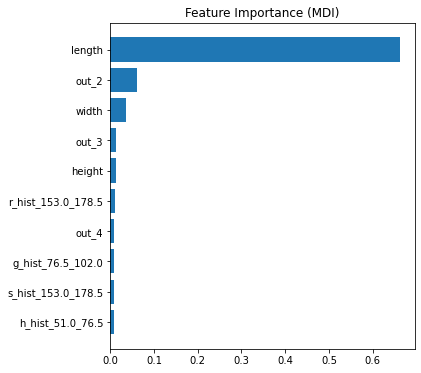

In [29]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos[-10:], feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos[-10:], np.array(data_X.columns)[sorted_idx][-10:])
plt.title('Feature Importance (MDI)')

# Добавим эмбеддинги

In [395]:
def predict_embedding(img, model):
    area = (750, 180, 1400, 970)
    img = img.crop(area)
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.cuda()
    model.eval()
    with torch.no_grad():
        pr_embed = model.features(batch_t)
        pr_embed = torch.nn.ReLU()(pr_embed)
        pr_embed = torch.nn.functional.adaptive_avg_pool2d(pr_embed, (1, 1))
    pr_embed = pr_embed.flatten().squeeze().cpu().numpy()
    return pr_embed 

In [427]:
cols = ['path']
for i in range(1, 1921):
    cols.append(f'emb_{i}')

In [428]:
df4 = pd.DataFrame(columns = cols)

densenet201.eval()   # Set model to evaluate mode

for path in nek['path']:
    img = Image.open(path)
    emb = predict_embedding(img, densenet201)
    dta = np.hstack((path, emb))
    df4 = df4.append(pd.DataFrame([dta], columns=df4.columns), ignore_index=True)  

In [429]:
nek = pd.merge(nek, df4, on=['path'])

In [431]:
#nek.to_csv('feature_table_emb_nek.csv')

In [30]:
nek = pd.read_csv('feature_table_emb_nek.csv')

In [31]:
nek

,Unnamed: 0,pack_id,path,length,width,height,k,volume,day,b_hist_0.0_25.5,...,emb_1911,emb_1912,emb_1913,emb_1914,emb_1915,emb_1916,emb_1917,emb_1918,emb_1919,emb_1920
0,0,2020_01_21_22_224923_М636МВ_1,part_1/21/224923_М636МВ10/FrontJPG/front6.jpg,600.0,236.0,182.0,0.54,13.916448,21,3968310.0,...,0.872095,0.115081,1.589560,1.662573,0.992428,2.269817,0.889906,0.700441,1.482369,1.475044
1,1,2020_01_21_22_224923_М636МВ_2,part_1/21/224923_М636МВ10/FrontJPG/front29.jpg,600.0,236.0,180.0,0.54,13.763520,21,1882206.0,...,0.914813,0.045133,0.535242,2.381262,0.401303,1.471654,1.204195,0.808816,1.274122,1.304659
2,2,2020_01_21_06_064710_М571ОМ_1,part_1/21/064710_м571ом10/FrontJPG/front14.jpg,300.0,226.0,176.0,0.64,7.636992,21,2566957.5,...,0.576421,1.557004,0.337310,0.620681,0.433425,0.469411,0.348359,0.348461,1.948384,0.451392
3,3,2020_01_21_06_064710_М571ОМ_2,part_1/21/064710_м571ом10/FrontJPG/front24.jpg,300.0,226.0,186.0,0.60,7.566480,21,3234394.5,...,0.217537,1.593439,0.712859,0.762881,0.210982,0.582210,1.114330,0.836422,1.856002,0.430947
4,4,2020_01_21_06_064710_М571ОМ_3,part_1/21/064710_м571ом10/FrontJPG/front40.jpg,300.0,226.0,170.0,0.60,6.915600,21,3356743.5,...,0.800847,0.498523,0.069789,0.672690,0.122032,0.171383,0.760376,0.564507,1.988554,0.161452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1560,1560,2020_01_27_20_204553_М496РУ_4,part_1/27/204553_м496ру10/FrontJPG/front52.jpg,300.0,234.0,240.0,0.67,11.288160,27,392496.0,...,0.693007,0.428602,0.294769,0.245616,0.825581,0.412798,0.209432,1.073762,0.513791,0.348519
1561,1561,2020_01_27_02_021645_М457РУ_1,part_1/27/021645_М457РУ10/FrontJPG/front15.jpg,550.0,230.0,210.0,0.59,15.673350,27,1306926.0,...,0.201890,0.628420,0.093939,0.712659,0.078209,0.385774,0.503405,0.501265,0.561256,0.035444
1562,1562,2020_01_27_02_021645_М457РУ_2,part_1/27/021645_М457РУ10/FrontJPG/front38.jpg,550.0,230.0,200.0,0.59,14.927000,27,752301.0,...,0.130185,1.503637,0.931121,0.842797,1.138544,0.404419,1.341011,1.702294,0.056420,0.185611
1563,1563,2020_01_27_17_174133_М493РУ_1,part_1/27/174133_м493ру10/FrontJPG/front8.jpg,600.0,232.0,180.0,0.52,13.029120,27,3880131.0,...,0.403985,1.247367,0.456841,1.968714,1.327365,0.577856,0.958550,1.099765,0.248462,0.005701


## Обучим бустинг

In [32]:
data = nek.drop(columns=['day', 'volume', 'path', 'pack_id', 'Unnamed: 0'])

In [33]:
data_X = data.drop(columns=['k'])
data_y = data['k']

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [35]:
scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2,
                                                    random_state=13)

In [45]:
params = {'n_estimators': 2500,
          'max_depth': 6,
          'min_samples_split': 5,
          'learning_rate': 0.002,
          'loss': 'ls'}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.002, max_depth=6, min_samples_split=5,
                          n_estimators=2500)

In [46]:
mae = mean_absolute_error(y_test, reg.predict(X_test))
mse = mean_squared_error(y_test, np.round(reg.predict(X_test), 2))
r2 = r2_score(y_test, np.round(reg.predict(X_test), 2))
mape = mean_absolute_percentage_error(y_test, np.round(reg.predict(X_test), 2))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("Rsquared on test set: {:.4f}".format(r2))
print("The mean absolute percentage error (MAPE) on test set: {:.4f}".format(mape))

The mean absolute error (MAE) on test set: 0.0089
The mean squared error (MSE) on test set: 0.0003
Rsquared on test set: 0.7970
The mean absolute percentage error (MAPE) on test set: 0.0137


In [47]:
data_X = data.drop(columns=['k'])
data_y = data['k']

Text(0.5, 1.0, 'Feature Importance (MDI)')

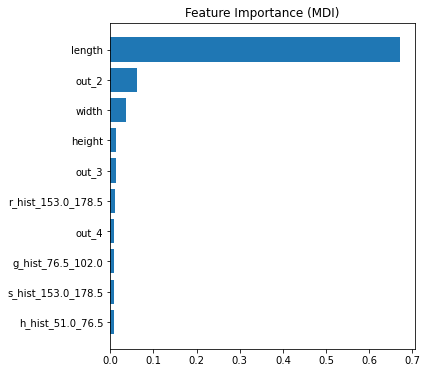

In [48]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos[-10:], feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos[-10:], np.array(data_X.columns)[sorted_idx][-10:])
plt.title('Feature Importance (MDI)')